In [9]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import chainer
import chainer.functions as F  
import chainer.links as L               
from chainer import computational_graph 
from chainer import serializers     

In [1]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [6]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [15]:
len(y_train)

60000

In [55]:
X_train = X_train.astype(np.float32)
y_train= y_train.astype(np.int32)

In [56]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=int32)

In [58]:
X_train[0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [48]:
y_train[0]

9

In [47]:
X_train /= 255

In [43]:
X_train.shape

(60000, 784)

In [44]:
y_train.shape

(60000,)

In [20]:
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

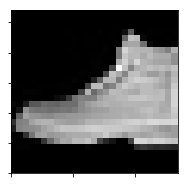

In [45]:
index = 50000
draw_digit(X_train[index])

In [22]:
y_train[index]

9

In [24]:
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 900)  # 第1層からの入力784､第2層への出力900
            self.l2=L.Linear(900, 1000) # 第2層からの入力600､第3層への出力1000
            self.l3=L.Linear(1000, 500) # 第3層からの入力1000､第4層への出力500
            self.l4=L.Linear(500, 10)   # 第4層からの入力500､出力層への出力10
        
    
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  # 1つめの隠れ層からの出力を計算
        h2 = F.relu(self.l2(h1)) # 2つめの隠れ層からの出力を計算
        h3 = F.relu(self.l3(h2)) # 3つめの隠れ層からの出力を計算
        return self.l4(h3)       # 出力層への入力を返す

In [25]:
model = L.Classifier(MLP())

In [26]:
gpu = -1 

In [27]:
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)   

In [28]:
batch_size = 100
n_epoch = 20

In [29]:
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [30]:
train = tuple_dataset.TupleDataset(X_train, y_train)

In [31]:
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [32]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)

In [33]:
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [34]:
test = tuple_dataset.TupleDataset(X_test,y_test)

In [35]:
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)

In [36]:
trainer.extend(extensions.Evaluator(test_iter, model))

In [37]:
trainer.extend(extensions.LogReport())

In [38]:
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [39]:
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [57]:
trainer.run()

3           2.3028      0.0997496                                                      


InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: in_types[0].dtype.kind == f
Actual: u != f

In [60]:
X_test = X_test.astype(np.float32)
y_test= y_test.astype(np.int32)

In [61]:
trainer.run()

4           2.3027      0.0966611                                                      


InvalidType: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: in_types[0].dtype.kind == f
Actual: u != f